# Tâche #2 : Classification d'incidents avec un réseau  récurrent et des *embeddings* Spacy

Cette tâche est similaire à la précédente et vous réutilisez les mêmes fichiers d’entraînement, de validation et de test. Cependant, vous devez utiliser des réseaux récurrents pour classifier les textes. Plus particulièrement, vous devez entraîner un réseau de neurones LSTM pour encoder les textes et une couche linéaire pour faire la classification des textes. 

Les consignes pour cette tâche sont: 
- 	Nom du notebook : rnn.ipynb
- 	Tokenisation : Utilisation de Spacy. 
- 	Plongements de mots : Ceux de Spacy. 
- 	Normalisation : Aucune normalisation. 
- 	Structure du réseau : Un réseau LSTM avec 1 seule couche pour l’encodage de textes. Je vous laisse déterminer la taille de cette couche (à expliquer). 
- 	Analyse : Comparer les résultats obtenus avec un réseau unidirectionnel et un réseau bidirectionnel. Si vous éprouvez des difficultés à entraîner les 2 réseaux dans un même notebook, faites une copie et nommez le 2e fichier rnn-bidirectionnel.ipynb.
- 	Expliquez comment les modèles sont utilisés pour faire la classification d’un texte. 
- 	Présentez clairement vos résultats et faites-en l’analyse. 


Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code. 
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc. 
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle. 

## 1. Création du jeu de données (*dataset*)

In [46]:
import json
from sklearn.model_selection import train_test_split
import spacy
import numpy as np
import torch
from torch import nn
from torch import FloatTensor, LongTensor
from poutyne.framework import Experiment
from poutyne import set_seeds
from torch.nn.functional import softmax
from numpy import argmax
from torch import LongTensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim import Adam
from torch import cuda
from PIL import Image
import matplotlib.pyplot as plt

device= 'cuda' if cuda.is_available() else 'cpu'

In [31]:
def load_dataset(filename):
    with open(filename, 'r') as infile:
        content = json.load(infile)
    return [el["text"] for el in content] ,[int(el["label"]) for el in content]

train_dataset_path = "./data/incidents_train.json"
train_texts,train_label = load_dataset(train_dataset_path)
test_dataset_path = "./data/incidents_test.json"
test_texts,test_label  = load_dataset(test_dataset_path)
validation_dataset_path = "./data/incidents_dev.json"
validation_texts,validation_label  = load_dataset(validation_dataset_path)
target_labels=sorted(set(train_label))
nb_classes=len(target_labels)

## 2. Gestion de plongements de mots (*embeddings*)

In [32]:
nlp = spacy.load('en_core_web_md')
embedding_size = nlp.meta['vectors']['width']
unk_id = 1
padding_id = 0
unk_token = '<UNK>'
padding_token = '<PAD>'

In [33]:
def get_vocabulary(corpus, padding=True):
    token_set = set()
    for text in corpus:
        tokens = nlp(text)
        for token in tokens:
            token_set.add(token.text)
    vocabulary = list(token_set)
    if padding:
        vocabulary.insert(padding_id, padding_token)
        vocabulary.insert(unk_id, unk_token)
    return vocabulary

def convert_to_id(text, word_to_index):
    tokens = nlp(text)
    return [word_to_index[token.text] for token in tokens]

def get_padding_embedding(dimension):
    return [0] * dimension

def get_embedding_tensor(vocab, spacy_analyzer, padding=True):
    pseudo_text = " ".join(vocab)
    doc = spacy_analyzer(pseudo_text)
    embeddings = [token.vector for token in doc]
    if padding:
        embedding_dim = len(embeddings[0])
        padding_emb = get_padding_embedding(embedding_dim)
        embeddings.insert(padding_id, padding_emb)
    return FloatTensor(embeddings)

In [34]:
vocab = get_vocabulary(train_texts)
embeddings_tensor = get_embedding_tensor(vocab, nlp, False)
embedding_layer = nn.Embedding.from_pretrained(embeddings_tensor)

In [35]:
def pad_batch(batch):
    x = [x for x,y in batch]
    x_true_length = [len(x) for x,y in batch]
    y = torch.stack([y for x,y in batch], dim = 0)
    return ((pad_sequence(x, batch_first=True), x_true_length), y)

class IncidentDataset(Dataset):
    def __init__(self, data , targets, word_to_id, spacy_model):
        self.data = data
        self.sequences = [None for _ in range(len(data))]
        self.targets = targets
        self.word2id = word_to_id
        self.tokenizer = spacy_model

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.sequences[index] is None:
            self.sequences[index] = self.tokenize(self.data[index])
        return LongTensor(self.sequences[index]).to(device), LongTensor([self.targets[index]]).squeeze(0).to(device)

    def tokenize(self, sentence):
        tokens = [word.text for word in self.tokenizer(sentence)]
        return [self.word2id.get(token, 1) for token in tokens]  # get(token, 1) retourne 1 par défaut si mot inconnu

In [36]:
word_to_index = {word: index for index, word in enumerate(vocab)}

train_dataset = IncidentDataset(train_texts, train_label, word_to_index, nlp)
validation_dataset = IncidentDataset(validation_texts, validation_label, word_to_index, nlp)
test_dataset = IncidentDataset(test_texts, test_label, word_to_index, nlp)

## 3. Création de modèle(s)

In [37]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_layer, nb_classes, bidirectional = False) :
        super().__init__()
        self.hidden_state = None
        self.embedding_layer = embedding_layer
        self.lstm_network = nn.LSTM(input_size=input_size, hidden_size=hidden_size, bidirectional=bidirectional, batch_first=True)
        self.classification_layer = nn.Linear(hidden_size if not bidirectional else hidden_size * 2, nb_classes)
        self.lstm_network.to(device)

    def forward(self, x, x_lengths):
        x = self.embedding_layer(x)
        packed_batch = pack_padded_sequence(x, x_lengths, batch_first=True, enforce_sorted=False)
        lstm_out, self.hidden_state = self.lstm_network(packed_batch)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        lstm_out = lstm_out[:, -1]
        x = self.classification_layer(lstm_out)
        return x

## 4. Fonctions utilitaires

Vous pouvez mettre ici toutes les fonctions qui seront utiles pour les sections suivantes.

## 5. Entraînement de modèle(s)

In [63]:
input_dimension = embedding_size
hidden_dimension = 100
epochs = 25
learning_rate = 0.02
batch_size = 512


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_batch)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_batch)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_batch)

"""Unidirectionnel"""
model_unidirectional = LSTMClassifier(input_size=input_dimension, hidden_size=hidden_dimension,embedding_layer=embedding_layer,nb_classes=nb_classes, bidirectional=False)
optimizer_unidirectional = Adam(model_unidirectional.parameters(), lr=learning_rate)
experiment_unidirectional = Experiment("model/unidirectional_lstm_classification", model_unidirectional, optimizer=optimizer_unidirectional, task="classification")
model_unidirectional.to(device)
train_log_unidirection= experiment_unidirectional.train(train_dataloader, validation_dataloader, epochs=epochs, disable_tensorboard=True)

"""Bidirectionnel"""
model_bidirectional = LSTMClassifier(input_size=input_dimension, hidden_size=hidden_dimension,embedding_layer=embedding_layer,nb_classes=nb_classes, bidirectional=True)
optimizer_bidirectional = Adam(model_bidirectional.parameters(), lr=learning_rate)
experiment_bidirectional = Experiment("model/bidirectional_lstm_classification", model_bidirectional, optimizer=optimizer_bidirectional, task="classification")
model_bidirectional.to(device)
train_log_bidirection= experiment_bidirectional.train(train_dataloader, validation_dataloader, epochs=epochs, disable_tensorboard=True)


Loading weights from model/unidirectional_lstm_classification\checkpoint.ckpt and starting at epoch 11.
Loading optimizer state from model/unidirectional_lstm_classification\checkpoint.optim and starting at epoch 11.
Loading random states from model/unidirectional_lstm_classification\checkpoint.randomstate and starting at epoch 11.
Epoch: 11/25 Train steps: 5 Val steps: 2 51.40s loss: 1.790678 acc: 38.868687 fscore_macro: 0.064503 val_loss: 1.789498 val_acc: 39.359699 val_fscore_macro: 0.062848
Epoch: 12/25 Train steps: 5 Val steps: 2 51.63s loss: 1.780553 acc: 38.828283 fscore_macro: 0.063870 val_loss: 1.774668 val_acc: 39.548023 val_fscore_macro: 0.066266
Epoch: 13/25 Train steps: 5 Val steps: 2 52.10s loss: 1.771782 acc: 38.787879 fscore_macro: 0.063387 val_loss: 1.766927 val_acc: 39.548023 val_fscore_macro: 0.066266
Epoch: 14/25 Train steps: 5 Val steps: 2 53.95s loss: 1.764201 acc: 38.828283 fscore_macro: 0.063772 val_loss: 1.767001 val_acc: 39.359699 val_fscore_macro: 0.062848
Ep

## 6. Évaluation et analyse de résultats

In [71]:
directory_name = "model/unidirectional_lstm_classification"
experiment = Experiment(directory_name, 
                        model_unidirectional, 
                        optimizer = optimizer_unidirectional, 
                        task="classification")
test_log_unidirection = experiment.test(test_dataloader)

Found best checkpoint at epoch: 2
lr: 0.02, loss: 2.08716, acc: 38.7475, fscore_macro: 0.0627678, val_loss: 2.0542, val_acc: 39.548, val_fscore_macro: 0.062978
Loading checkpoint model/unidirectional_lstm_classification\checkpoint_epoch_2.ckpt
Running test
Test steps: 2 8.57s test_loss: 2.067445 test_acc: 35.969868 test_fscore_macro: 0.058787         


In [72]:
directory_name = "model/bidirectional_lstm_classification"
experiment = Experiment(directory_name, 
                        model_bidirectional, 
                        optimizer = optimizer_bidirectional, 
                        task="classification")
test_log_bidirection=experiment.test(test_dataloader)

Found best checkpoint at epoch: 12
lr: 0.02, loss: 1.78616, acc: 38.7879, fscore_macro: 0.0638237, val_loss: 1.77764, val_acc: 39.548, val_fscore_macro: 0.0662665
Loading checkpoint model/bidirectional_lstm_classification\checkpoint_epoch_12.ckpt
Running test
Test steps: 2 0.85s test_loss: 1.833373 test_acc: 36.158192 test_fscore_macro: 0.062219         


In [82]:
data_objects = [
    test_log_unidirection,
    test_log_bidirection,
]

def showModelsResult():
    # Champs à comparer
    fields = ['test_loss', 'test_acc', 'test_fscore_macro']

    # Préparation des données pour le traçage
    data_to_plot = {field: [obj[field] for obj in data_objects] for field in fields}

    # Création du graphique
    fig, axs = plt.subplots(len(fields), figsize=(8, 6))

    # Couleurs différentes pour chaque objet
    colors = ['skyblue', 'lightcoral']

    # Barres avec couleurs différentes et texte en gras pour les valeurs maximales
    for i, field in enumerate(fields):
        for j, obj in enumerate(data_objects):
            bar = axs[i].bar(j, data_to_plot[field][j], color=colors[j])
            axs[i].text(j, data_to_plot[field][j], f'{data_to_plot[field][j]:.2f}', ha='center', va='bottom', fontweight='normal')
            if data_to_plot[field][j] == max(data_to_plot[field]):
                bar[0].set_linewidth(2)  # Augmente l'épaisseur de la barre pour la valeur maximale
                bar[0].set_edgecolor('black')  # Bordure noire pour la valeur maximale
                axs[i].text(j, data_to_plot[field][j], f'{data_to_plot[field][j]:.2f}', ha='center', va='bottom', fontweight='bold')

        axs[i].set_ylabel(field)
        axs[i].set_xticks(range(len(data_objects)))
        axs[i].set_xticklabels(["Unidirectionelle", "Bidirectionelle"])

    plt.tight_layout()
    plt.show()

### Fonctionnement du modèle : 
 
Les LSTM sont une variante des réseaux de neurones récurrents (RNN) conçus pour traiter les dépendances à long terme dans les séquences de données. Ils sont donc particulièrement adapté pour faire de la classification de texte.

Avant d'entraîner le modèle, nous devons calculer le plongement des phrases du jeu de données en utilisant la bibliothèque Spacy.
Les phrases ont été tokenisées en mots, puis chaque token est associé à son vecteur d'intégration correspondant. Ces vecteurs sont ensuite combinés pour former le plongement de la phrase

Notre modèle prend donc en entrée le plongement de la phrase à classsifier
La dernière couche a comme sortie le nombre de classes dans la tâche de classification.

Une fois le modèle entraîné, il peut être utilisé, pour cela on calcule le plongement de la phrases en entrée, puis ce plongement est fourni en entrée au modèle LSTM à une couche pour obtenir la prédiction de classe.

Tout comme pour la tâche 1, nous devons régler certain paramètres d'apprentissages avant d'entrainer complétement nos modèles.
Voici les paramètres à régler.

- Le nombre d'epoch, c'est à dire le nombre d'itération d'entrainement sur l'ensemble du dataset.
- Le nombre de neurones de la couche cachée.
- Le taux d'apprentissage
- Le batch size

Nous allons ici utiliser l'optimiseur Adam car selon nos test il donne les meileurs résultats.

Le batch_size (la taille de lot) représente le nombre d'échantillons de données qui sont présentés au modèle lors d'un epoch.
L'utilisation d'un batch_size assez grand permet de traiter plusieurs exemples en parallèle, ce qui peut accélérer le processus d'entraînement. De même les modèles avec un batch_size relativement élevé sont plus stable et converge plus vite. Cependant un batch_size élevé necessite plus de mémoire RAM. Dans notre cas nous avons assez de mémoire pour mettre le batch_size à la taille du jeu d'entrainement, cependant avoir un batch_size aussi gros pourrait faire converger le modèle dans un minimum local, ainsi un batch_size de 512 devrait être un bon compromis.
Sur des modèle plus gros on prend toujours le batch_size le plus grand possible il est très rare d'avoir assez de mémoire pour converger dans un minimum local à cause d'un batch_size trop élevé.

Nous allons déterminer le taux d'apprentissage avec la même méthode que la tâche 1. Nous allons lancer des entrainements avec les taux d'apprentissage de 0.1, 0.05, 0.02, 0.01 et 0.001 sur le modèle unidirectionel. Pour que l'apprentissage soit rapide, on prend 15 epochs sur 20 paramètres sur la couche cachée.

Et voici les courbes de pertes obtenus pour les taux d'apprentissage.

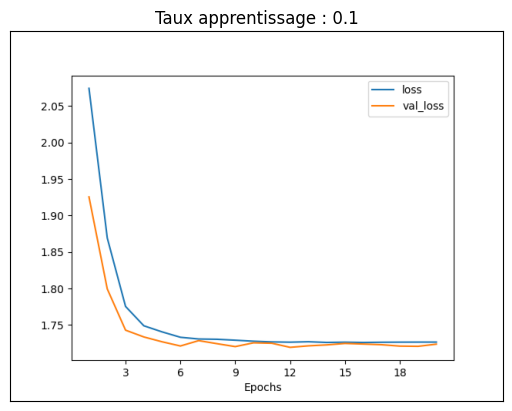

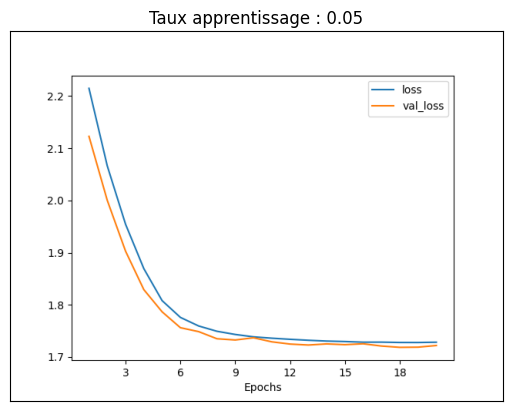

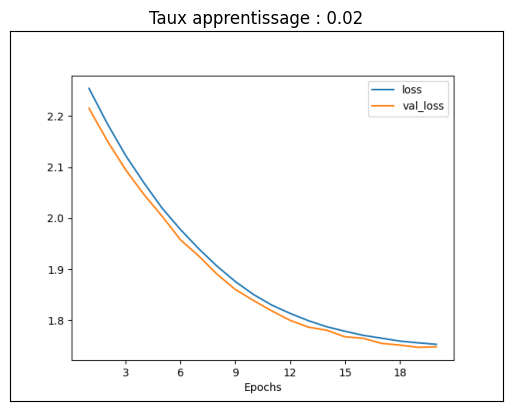

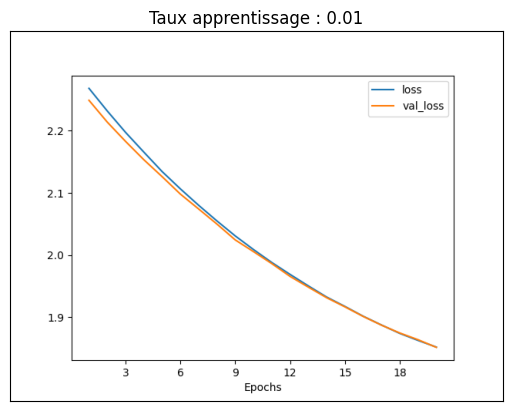

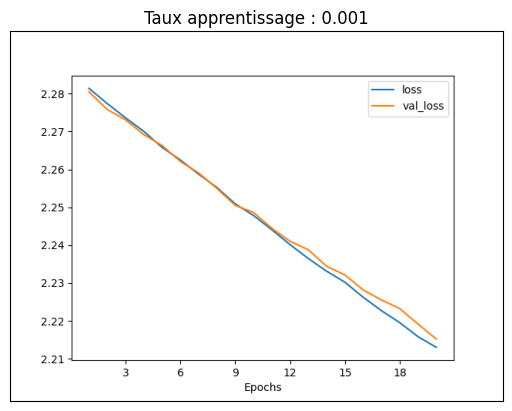

In [56]:
def show(path, title):    
    img = np.asarray(Image.open(path))
    plt.title(title)
    fig = plt.imshow(img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

show('./Analyse/t2lr/lr0,1/loss.png', 'Taux apprentissage : 0.1')
show('./Analyse/t2lr/lr0,05/loss.png', 'Taux apprentissage : 0.05')
show('./Analyse/t2lr/lr0,02/loss.png', 'Taux apprentissage : 0.02')
show('./Analyse/t2lr/lr0,01/loss.png', 'Taux apprentissage : 0.01')
show('./Analyse/t2lr/lr0,001/loss.png', 'Taux apprentissage : 0.001')

On remarque que pour un taux d'apprentissage de 0.1, la courbe décroit extrêmement rapidement puis ne converge plus du tout passer 6 epoch, cela est signe d'un taux apprentissage trop élevé.
De même on remarque que pour un taux de 0.001 la courbe décroit linéairement, cela montre un taux trop faible qui va converger trop lentement.
Pour un taux d'apprentissage de 0.01 on a une exponentielle décroissante mais qui n'est pas très prononcé. Un taux de 0.05 rend également une exponentielle décroissante mais qui elle est pour le coup trop prononcé. Nous allons donc prendre un taux d'apprentissage de 0.02 qui est un très bon compromis.


Pour évaluer le nombre de paramètres de la couche cachée on va également faire comme dans la tâche 1 et lancer plusieurs entrainement sur peu d'epoch en changeant le nombre de paramètres de la couche cachée. Nous voulons un maximum de paramètre possible mais avec un modèle qui converge en un temps raisonable.

On lance donc l'entrainement du modèle unidirectionelle sur 30, 60 et 100 paramètres pour la couche cachée avec un nombre d'epoch faible (10) pour que l'apprentissage reste rapide.
Prendre plus de paramètres rendait le modèle trop long à entrainer, d'ou le fait de s'arrêter à 100.

Voici la courbe de précision des modèles pour les valeurs de la taille de couche cité précedement : 

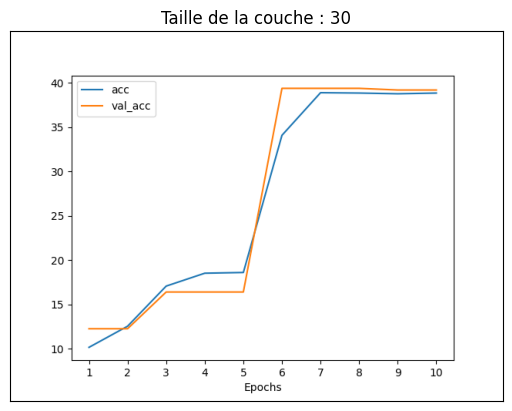

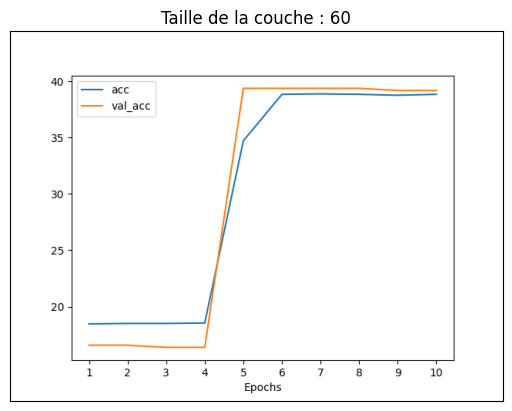

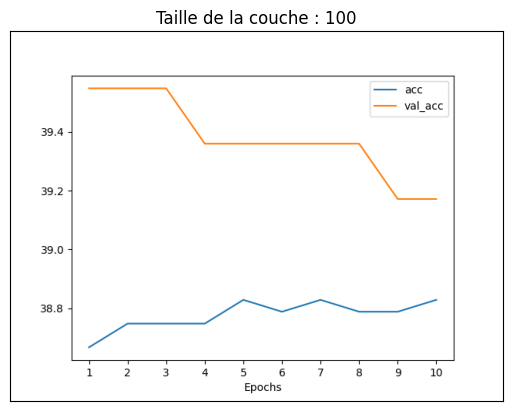

In [83]:
show('./Analyse/t2size/30/acc.png', 'Taille de la couche : 30')
show('./Analyse/t2size/60/acc.png', 'Taille de la couche : 60')
show('./Analyse/t2size/100/acc.png', 'Taille de la couche : 100')

Comme on peut le remarquer dans ces graphiques, les modèles à 30 et 60 neurones par couche cachée ont déjà convergé après 6 epochs. Celui à 100 paramètre n'a pas encore convergé, il a donc plus de potentiel, nous allons garder ce modèle.

On lance ainsi un dernier entrainement des modèles unidirectionelle et bidirectionnelle avec un taux d'apprentissage de 0.02, 100 neurones par couche cachée, un batch_size de 512 et sur 25 epoch.

Voici les résultats des 2 modèles : 

Unidirectionelle : 


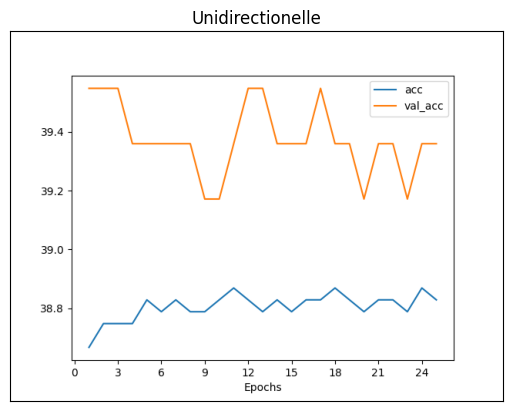

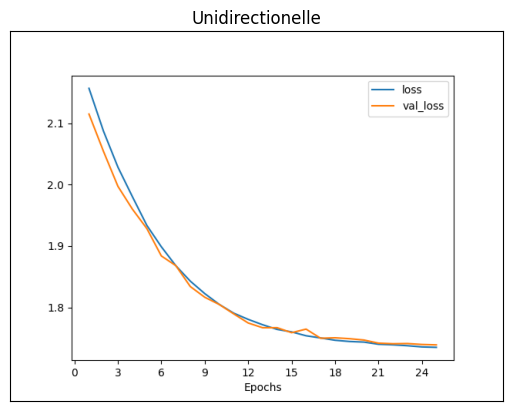

Bidirectionelle : 


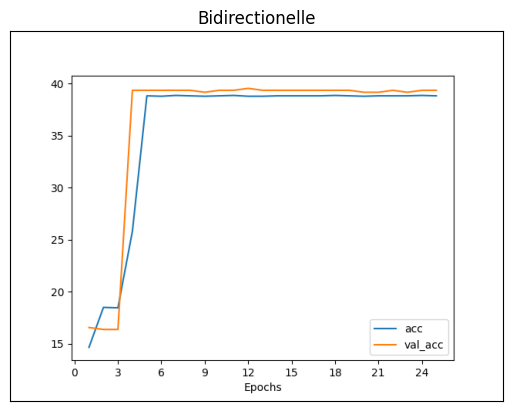

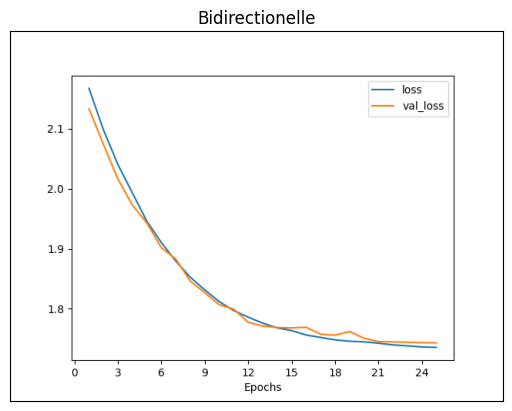

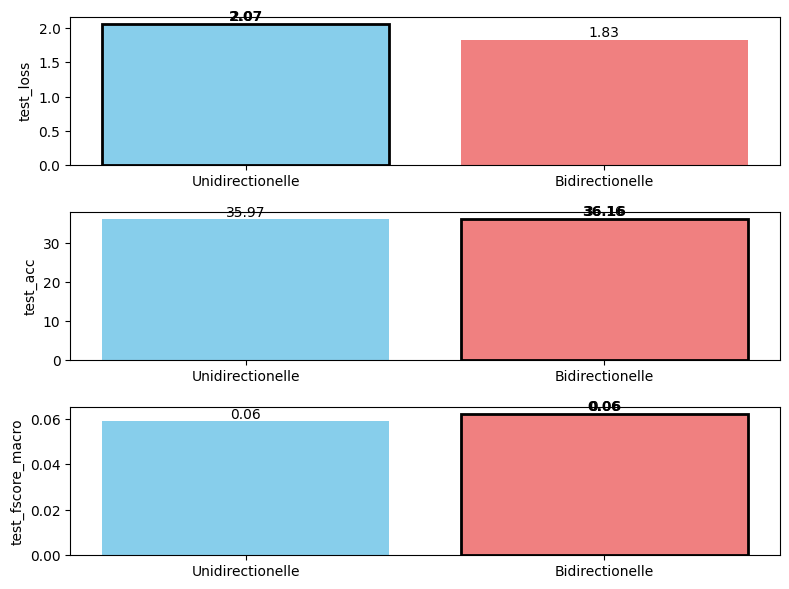

In [84]:
print("Unidirectionelle : ")
show('./Analyse/t2last/uni/acc.png', 'Unidirectionelle')
show('./Analyse/t2last/uni/loss.png', 'Unidirectionelle')

print("Bidirectionelle : ")
show('./Analyse/t2last/bi/acc.png', 'Bidirectionelle')
show('./Analyse/t2last/bi/loss.png', 'Bidirectionelle')

showModelsResult()

On remarque que les résultats entre les deux modèle sont très similaire, bien que la perte est légèrement inférieur pour le diagramme Bidirectionelle.
Cela peut s'expliquer car notre jeu de données d'entrainement est assez limité, les modèles bidirectionelles exploitent en général mieux les jeux de données très volimineux. De plus les modèles bidirectionelles exploitent mieux les données d'entrées assez longues, ce n'est pas le cas ici car les descriptions d'incidents sont relativement courtes, peut être qu'avec des phrases d'entrée plus longue le modèle bidirectionelle serait meilleur.
En tout cas les performances de ces modèles ne dépassent pas 36% ce qui est largement moins bien que les résultats obtenues lors de la tâche 1, en sachant que l'entrainement a été nettement plus long ici.